# XPCS Pipeline for SAXS
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Clean Data: shutter open/bad frames
* Get Q-Map
* Get 1D curve
* Define Q-ROI (qr, qz)
* Check beam damage
* One-time Correlation
* Fitting
* Two-time Correlation
The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Setup

Import packages for I/O, visualization, and analysis.

In [166]:
from chxanalys.chx_libs import (np, roi, time, datetime, os, get_events, 
                                getpass, db, get_images,LogNorm, plt,tqdm, utils, Model)

from chxanalys.chx_generic_functions import (get_detector, get_fields, get_sid_filenames,  
     load_data, load_mask,get_fields, reverse_updown, ring_edges,get_avg_img,check_shutter_open,
    apply_mask, show_img,check_ROI_intensity,run_time, plot1D, get_each_frame_intensity,                                             
    create_hot_pixel_mask,show_ROI_on_image,create_time_slice,save_lists, 
                        save_arrays, psave_obj,pload_obj, get_non_uniform_edges )
 

from chxanalys.XPCS_SAXS import (get_circular_average,save_lists,get_ring_mask, get_each_ring_mean_intensity,
                                 plot_qIq_with_ROI,save_saxs_g2,plot_saxs_g2,fit_saxs_g2,cal_g2,
                                create_hot_pixel_mask,get_circular_average,get_t_iq,save_saxs_g2,
                                plot_saxs_g2,fit_saxs_g2,fit_q2_rate,plot_saxs_two_g2,fit_q_rate,
                                circular_average,plot_saxs_g4, get_t_iqc,multi_uids_saxs_xpcs_analysis)


from chxanalys.Two_Time_Correlation_Function import (show_C12, get_one_time_from_two_time,
                                                get_four_time_from_two_time,rotate_g12q_to_rectangle)

from chxanalys.chx_compress_analysis import ( compress_eigerdata, read_compressed_eigerdata,
                                             Multifile,get_avg_imgc, get_each_frame_intensityc,
                get_each_ring_mean_intensityc, mean_intensityc,cal_waterfallc,plot_waterfallc)

from chxanalys.SAXS import fit_form_factor
from chxanalys.chx_correlationc import ( cal_g2c,Get_Pixel_Arrayc,auto_two_Arrayc,get_pixelist_interp_iq,)
from chxanalys.chx_correlationp import (cal_g2p, auto_two_Arrayp)

from chxanalys.Create_Report import (create_pdf_report, 
                                create_multi_pdf_reports_for_uids,create_one_pdf_reports_for_uids)


from chxanalys.XPCS_GiSAXS import (get_qedge,get_qmap_label,get_qr_tick_label, get_reflected_angles,
    convert_gisaxs_pixel_to_q, show_qzr_map, get_1d_qr, get_qzrmap, show_qzr_roi,get_each_box_mean_intensity,
    save_gisaxs_g2,plot_gisaxs_g2, fit_gisaxs_g2,plot_gisaxs_two_g2,plot_qr_1d_with_ROI,fit_qr_qz_rate,
                                  multi_uids_gisaxs_xpcs_analysis,plot_gisaxs_g4)

%matplotlib notebook

In [129]:
plt.rcParams.update({'figure.max_open_warning': 0})

In [130]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [131]:
print("NOTEBOOK_FULL_PATH:\n", NOTEBOOK_FULL_PATH)

NOTEBOOK_FULL_PATH:
 /user/yuzhang/analysis/2016_3/commissioning/XPCS_SAXS_Multi_Run_Nov-10nm Au.ipynb


## Make a directory for saving results

In [167]:
CYCLE = '2016_3'
username = getpass.getuser()
username = "commissioning"

date_path = datetime.now().strftime('%Y/%m/%d')  # e.g., '2016/03/01'
data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')

##Or define data_dir here, e.g.,#data_dir = '/XF11ID/analysis/2016_2/rheadric/test/'

os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_3/commissioning/Results/


## Load Metadata & Image Data

Print detector, scan-id, uid, datapath of data collected.

# Change these lines to get data

In [168]:

start_time, stop_time = '2016-10-31  11:15:00', '2016-10-31  11:21:00'  
start_time, stop_time = '2016-10-31  14:22:00', '2016-10-31  14:30:00' 

start_time, stop_time = '2016-10-31  18:02:00', '2016-10-31  18:08:00' 
#count : 1 ['8c9112'] (scan num: 126) (Measurement: PSPMMA1b 200C 50 x.002s 2s period_run_0_0 )

hdrs = db(start_time= start_time, stop_time = stop_time)
print ('Totally %s uids are found'%(len(hdrs)))
sids=[]
uids=[]

for hdr in hdrs:
    s= get_sid_filenames( hdr)
    print (s)
    sids.append( s[0] )
    uids.append( s[1] )
sids=sids[::-1]
uids=uids[::-1]

uid = uids[0]

Totally 10 uids are found
(4186, 'e12c3f54-2f9a-4a97-8ae9-bd65cd404dc4', ['/XF11ID/data/2016/10/31/89a6715f-8bc8-4a92-89ef_841'])
(4185, '7444de2e-f85e-4afb-95b0-202fcf310f2f', ['/XF11ID/data/2016/10/31/0c7e29ce-6122-412c-956d_840'])
(4184, 'bac795fe-2af2-44a4-82ff-84b17a5bbd6b', ['/XF11ID/data/2016/10/31/0d552934-d6f7-4217-8360_839'])
(4183, '01e8d570-799e-41f7-8160-58a8ecfc15c4', ['/XF11ID/data/2016/10/31/614353da-be4e-454f-9681_838'])
(4182, 'c6c9e4c8-dd3e-4962-85bd-86c51a60f1b6', ['/XF11ID/data/2016/10/31/c4f0bf5a-6f18-4dfe-9404_837'])
(4181, '86525263-e276-4e87-b3e7-fdc887fa3e60', ['/XF11ID/data/2016/10/31/76456769-3b84-4cdd-921e_836'])
(4180, '2fd26d5f-accb-4908-9d1e-da105e683932', ['/XF11ID/data/2016/10/31/9deeb5de-9c36-40c5-8b74_835'])
(4179, 'e56ddbe5-6e10-4b79-88d1-5f0949e325b5', ['/XF11ID/data/2016/10/31/c99f6bce-7169-4592-9e22_834'])
(4178, 'aa9983e3-979c-4010-8c13-a44f14026820', ['/XF11ID/data/2016/10/31/128de9e0-2e82-4bc1-8ea0_833'])
(4177, 'a36e6012-8863-4777-81ce-178287

In [169]:
uid_=  'Au10nm_PEG-10wt-Octo31' #give a meaningful folder name

data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/%s/'%uid_)

os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_3/commissioning/Results/Au10nm_PEG-10wt-Octo31/


In [170]:
data_dir_ = os.path.join( data_dir, 'Average/')
os.makedirs(data_dir_, exist_ok=True)
print ( data_dir_)

/XF11ID/analysis/2016_3/commissioning/Results/Au10nm_PEG-10wt-Octo31/Average/


# Don't Change these lines below here

In [171]:
detector = get_detector( db[uid ] )
print ('Detector is:  %s'%detector  )
sud = get_sid_filenames(db[uid])
print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], sud[2][0] ))

Detector is:  eiger4m_single_image
scan_id, full-uid, data path are:  4177--a36e6012-8863-4777-81ce-1782877d4c3f--/XF11ID/data/2016/10/31/ecb639c1-737e-492a-b470_832


In [172]:
imgs = load_data( uid, detector  )
Nimg = len(imgs)
md = imgs.md

hdf5 path = /XF11ID/data/2016/10/31/ecb639c1-737e-492a-b470_832_master.h5


In [173]:
try:
    md['Measurement']= db[uid]['start']['Measurement']
    md['sample']=db[uid]['start']['sample']     
    m#d['sample']= 'PS205000-PMMA-207000-SMMA3'
    print( md['sample'])
    
except:
    md['Measurement']= 'Measurement'
    md['sample']='sample'

In [174]:
imgs

<Frames>
Length: 200 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint16

## Overwrite Some Metadata Due to Wrong Input

In [175]:
md

{'Measurement': 'Measurement',
 'beam_center_x': 1476.0,
 'beam_center_y': 789.0,
 'count_time': 0.00134,
 'detector_distance': 4.8899999,
 'frame_time': 0.00135,
 'incident_wavelength': 1.2848103,
 'pixel_mask': array([[0, 0, 0, ..., 0, 0, 4],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint32),
 'sample': 'sample',
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

In [176]:
# The physical size of the pixels
dpix = md['x_pixel_size'] * 1000.  #in mm, eiger 4m is 0.075 mm
lambda_ =md['incident_wavelength']    # wavelegth of the X-rays in Angstroms

Ldet = 4.84 * 1000          # detector to sample distance (mm), currently, *1000 for saxs, *1 for gisaxs

exposuretime= md['count_time']
acquisition_period = md['frame_time']
print( 'The sample is %s'%(  md['sample']  ))
print( 'Exposuretime=%s sec, Acquisition_period=%s sec'%( exposuretime, acquisition_period  ))
timeperframe = acquisition_period#for g2
#timeperframe = exposuretime#for visiblitly

#timeperframe = 2  ## manual overwrite!!!! we apparently writing the wrong metadata....

 
center = [   1331,1357  ]  # center of the speckle pattern, read from [image_x, image_y], ((not python y,x))
center = [   1342, 1367  ]  # center of the speckle pattern, read from [image_x, image_y], ((not python y,x))


center = [1475-4, 1381-0] 
center=[center[1], center[0]]
print ('Beam center=', center)




The sample is sample
Exposuretime=0.00134 sec, Acquisition_period=0.00135 sec
Beam center= [1381, 1471]


In [177]:
setup_pargs=dict(uid=uid_, dpix= dpix, Ldet=Ldet, lambda_= lambda_, 
        timeperframe=timeperframe, center=center, path= data_dir_, md=md)

In [178]:
setup_pargs

{'Ldet': 4840.0,
 'center': [1381, 1471],
 'dpix': 0.075000003562308848,
 'lambda_': 1.2848103,
 'md': {'Measurement': 'Measurement',
  'beam_center_x': 1476.0,
  'beam_center_y': 789.0,
  'count_time': 0.00134,
  'detector_distance': 4.8899999,
  'frame_time': 0.00135,
  'incident_wavelength': 1.2848103,
  'pixel_mask': array([[0, 0, 0, ..., 0, 0, 4],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ..., 
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint32),
  'sample': 'sample',
  'x_pixel_size': 7.5000004e-05,
  'y_pixel_size': 7.5000004e-05},
 'path': '/XF11ID/analysis/2016_3/commissioning/Results/Au10nm_PEG-10wt-Octo31/Average/',
 'timeperframe': 0.00135,
 'uid': 'Au10nm_PEG-10wt-Octo31'}

## Apply Mask
* load and plot mask if exist 
* otherwise create a mask using Mask pipeline
* Reverse the mask in y-direction due to the coordination difference between python and Eiger software
* Reverse images in y-direction
* Apply the mask

# Change these lines

In [179]:

mask_path = '/XF11ID/analysis/2016_3/masks/'
mask_name = 'Octo28_4M_mask.npy'

<IPython.core.display.Javascript object>


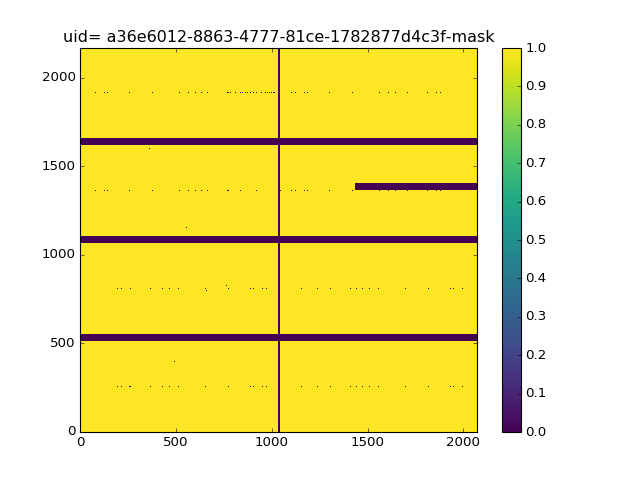

In [180]:
mask = load_mask(mask_path, mask_name, plot_ =  True, image_name = 'uid= %s-mask'%uid )

# Save metadata into the uid folder
* save mask file
* save the metadata dict

In [182]:
md['mask'] = mask
md['mask_file']= mask_path + mask_name 
md['NOTEBOOK_FULL_PATH'] = NOTEBOOK_FULL_PATH
#psave_obj(  md, data_dir + 'uid=%s-md'%uid ) #save the setup parameters
#md = pload_obj(data_dir + 'uid=%s-md'%uid  )

In [183]:
imgsa = apply_mask( imgs, mask )

<IPython.core.display.Javascript object>


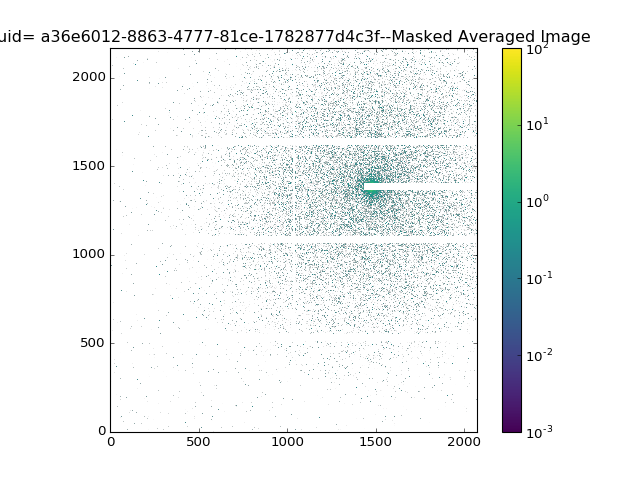

In [184]:
avg_img =  get_avg_img( imgsa, sampling = int(Nimg/3), plot_ = True, uid =uid)

<IPython.core.display.Javascript object>


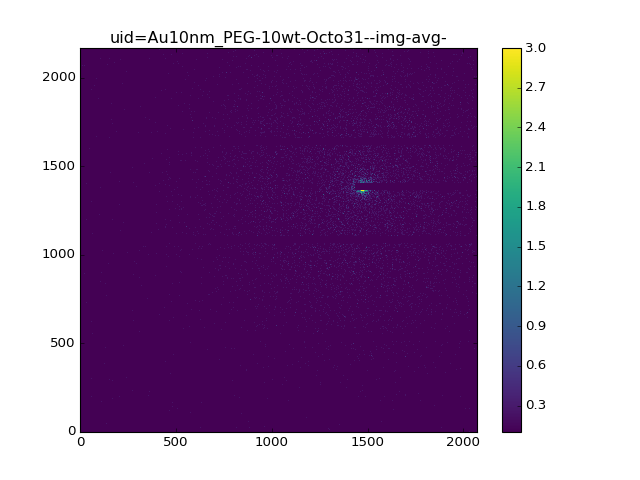

In [185]:
#avg_img = get_avg_imgc( FD,  beg=0,end=10000,sampling = 1, plot_ = False )
show_img( avg_img,  vmin=.1, vmax=3.0, logs=False, image_name= 'uid=%s--img-avg-'%uid_,
        save=True, path=data_dir_) 
md['avg_img'] = avg_img

# Suppose we have all the parameters to define ROIs, if not use the "Single_Data" Pipeline

### Get circular average 
* Do plot and save q~iq


<IPython.core.display.Javascript object>


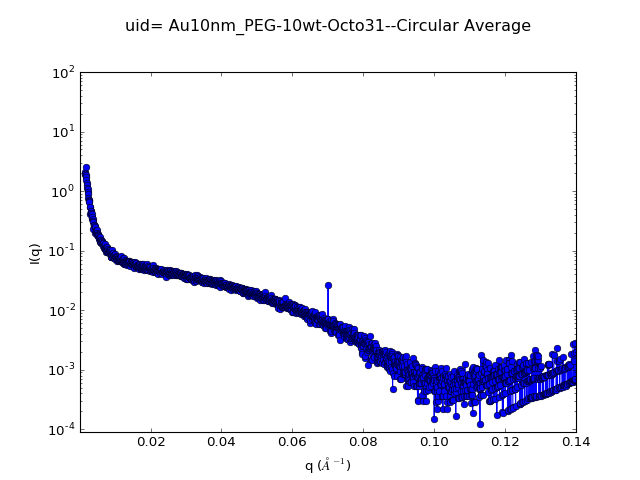

In [188]:
hmask = create_hot_pixel_mask( avg_img, 2**15 )
mask = mask * hmask
hmask = create_hot_pixel_mask( avg_img, 1e8)
qp, iq, q = get_circular_average( avg_img, mask * hmask, pargs=setup_pargs, nx=None,
            plot_ = True, show_pixel= False, xlim=[0.0001,.14], ylim = [0.00009, 1e2], save=True)



### Define ROI
* Create ring mask defined by  inner_radius, outer_radius, width, num_rings (all in pixel unit)
* Create ring mask defined by  edges (all in pixel unit)

In [189]:
uniform = True

### Define a non-uniform distributed rings by giving edges

In [88]:
if not uniform:
    #width = 4  # in pixel
    width = 0.001    
    number_rings=1
    #centers = [ 31, 50, 67, 84, 102, 119] #in pixel
    centers = [ 0.00235,0.00379,0.00508,0.00636,0.00773, 0.00902] #in A-1
    centers = [ 0.0065,0.0117,0.021,0.0336,0.044, 0.057] #in A-1
    edges = get_non_uniform_edges(  centers, width, number_rings )
    
    inner_radius= None
    outer_radius = None
    width = None
    num_rings = None

### Define a uniform distributed rings by giving inner_radius, outer_radius, width, num_rings (all in pixel unit)

In [190]:
if uniform:
    inner_radius= 0.0018
    outer_radius = 0.04
    width = 0.0035
    num_rings = 10
    edges = None

In [191]:
ring_mask, q_ring_center, q_ring_val = get_ring_mask(  mask, inner_radius=inner_radius, unit='A',
        outer_radius = outer_radius , width = width, num_rings = num_rings, edges=edges, pargs=setup_pargs   )
qind, pixelist = roi.extract_label_indices(  ring_mask  ) 

In [192]:
md['center'] = center
md['ring_mask'] = ring_mask
md['q_ring_center']= q_ring_center
md['q_ring_val'] = q_ring_val
md['beam_center_x'] =  center[1]
md['beam_center_y']=  center[0]
md['data_dir'] = data_dir

psave_obj(  md, data_dir_ + 'uid=%s-md'%uid_ ) #save the setup parameters

In [193]:
#pload_obj(   data_dir + 'uid=%s-md'%uid_  )

<IPython.core.display.Javascript object>


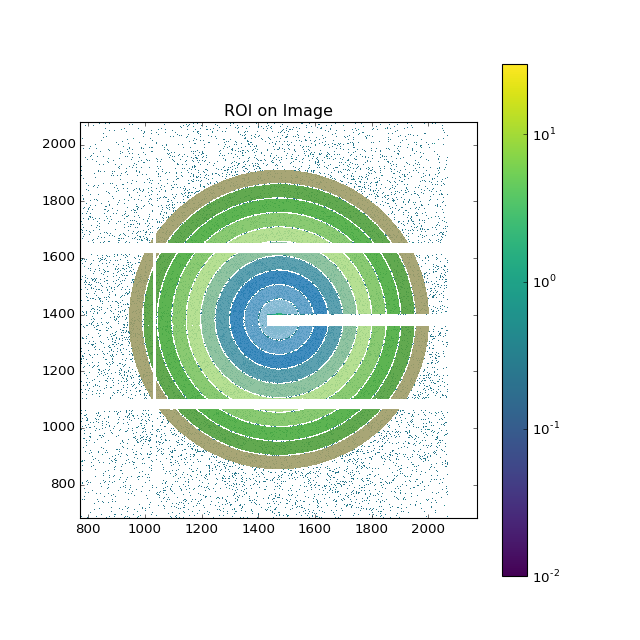

In [194]:
show_ROI_on_image( avg_img, ring_mask, center, label_on = False, rwidth=700, alpha=.9, 
                  vmax=30, save=True, path=data_dir_, uid=uid_)

<IPython.core.display.Javascript object>


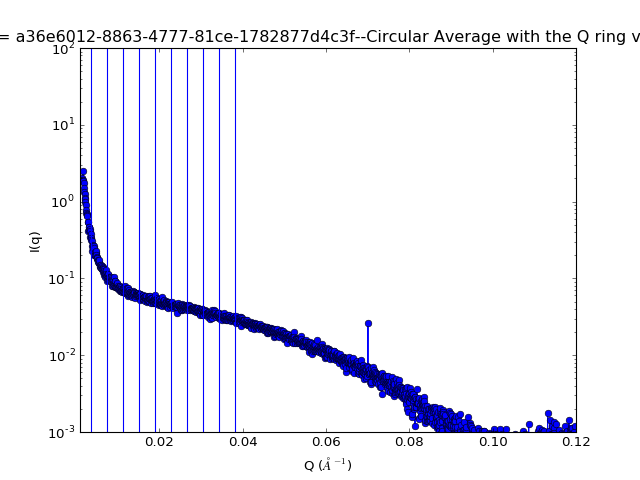

In [195]:
plot_qIq_with_ROI( q, iq, q_ring_center, logs=True, uid=uid, xlim=[0.001,.12],
                  ylim = [1e-3, 1e2],        save=True, path=data_dir)

# Do loop here

In [95]:
run_num = 1
sub_num = 10

In [96]:
data_dir

'/XF11ID/analysis/2016_3/commissioning/Results/Au10nm_PEG-10wt%--Octo31/'

  0%|          | 0/200 [00:00<?, ?it/s]

The 0--th uid to be analyzed is : a36e6012-8863-4777-81ce-1782877d4c3f
hdf5 path = /XF11ID/data/2016/10/31/ecb639c1-737e-492a-b470_832_master.h5
Create a new compress file with filename as :/XF11ID/analysis/Compressed_Data/uid_a36e6012-8863-4777-81ce-1782877d4c3f.cmp.


100%|██████████| 200/200 [00:19<00:00, 11.23it/s]


The fraction of pixel occupied by photon is  1.363% 
No bad frames are involved.
10nm Au PEG 10wt.% 750Hz 200fr
With compression, the good_start frame number is: 2 
In this g2 calculation, the buf and lev number are: 8--6--
198 frames will be processed...


100%|██████████| 198/198 [00:19<00:00,  9.89it/s]

G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/commissioning/Results/Au10nm_PEG-10wt%--Octo31/a36e6012-8863-4777-81ce-1782877d4c3f/ with filename as uid=a36e6012-8863-4777-81ce-1782877d4c3f--g2.csv


<IPython.core.display.Javascript object>


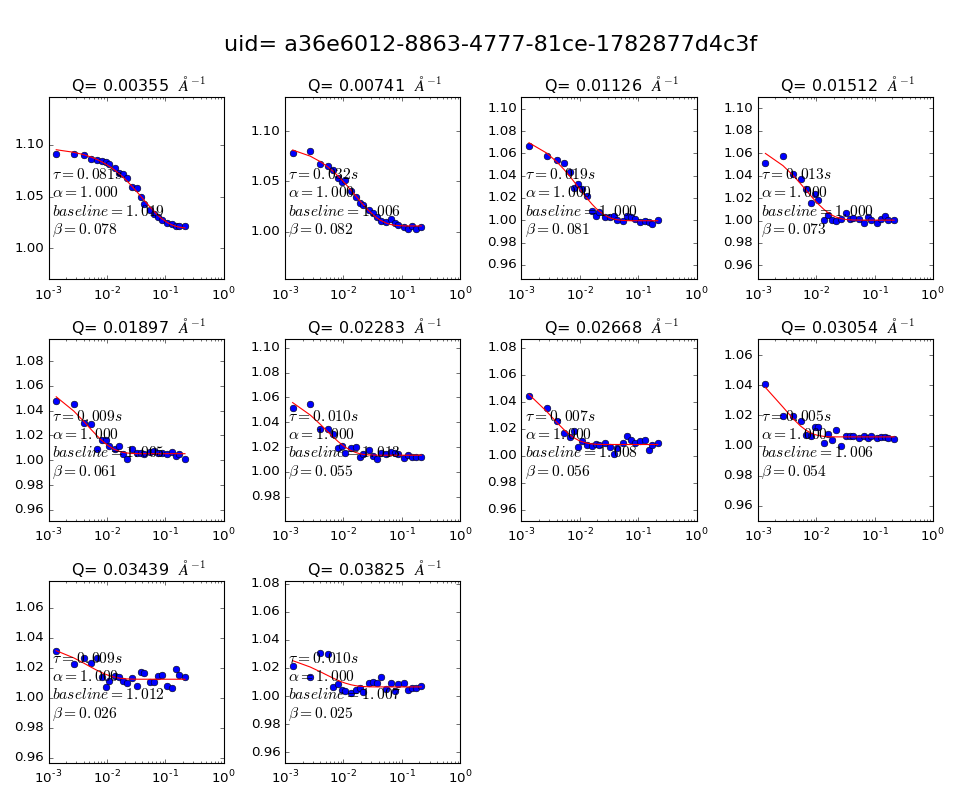

The fitted diffusion coefficient D0 is:  1.258e+05   A^2S-1


<IPython.core.display.Javascript object>


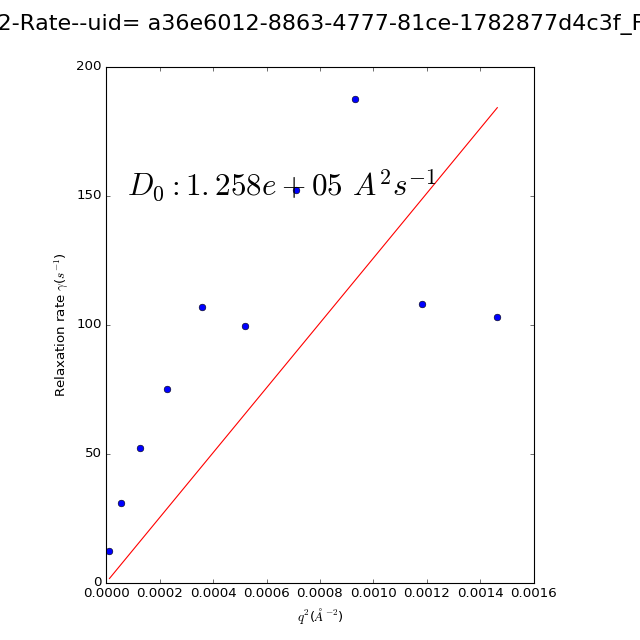

  0%|          | 1/200 [00:00<00:21,  9.29it/s]

****************************************

The 1--th uid to be analyzed is : aa9983e3-979c-4010-8c13-a44f14026820
hdf5 path = /XF11ID/data/2016/10/31/128de9e0-2e82-4bc1-8ea0_833_master.h5
Create a new compress file with filename as :/XF11ID/analysis/Compressed_Data/uid_aa9983e3-979c-4010-8c13-a44f14026820.cmp.


100%|██████████| 200/200 [00:19<00:00, 10.80it/s]


The fraction of pixel occupied by photon is  1.356% 
No bad frames are involved.
10nm Au PEG 10wt.% 750Hz 200fr
With compression, the good_start frame number is: 2 


  0%|          | 0/198 [00:00<?, ?it/s]

In this g2 calculation, the buf and lev number are: 8--6--
198 frames will be processed...


100%|██████████| 198/198 [00:19<00:00, 10.02it/s]

G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/commissioning/Results/Au10nm_PEG-10wt%--Octo31/aa9983e3-979c-4010-8c13-a44f14026820/ with filename as uid=aa9983e3-979c-4010-8c13-a44f14026820--g2.csv


<IPython.core.display.Javascript object>


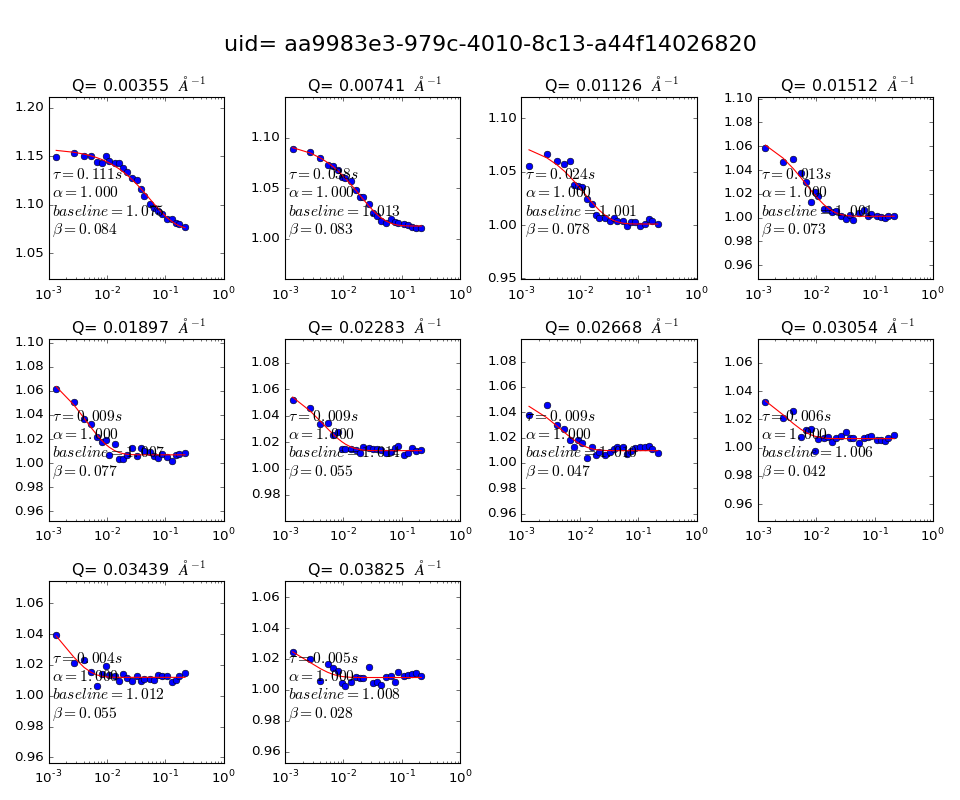

The fitted diffusion coefficient D0 is:  1.781e+05   A^2S-1


<IPython.core.display.Javascript object>


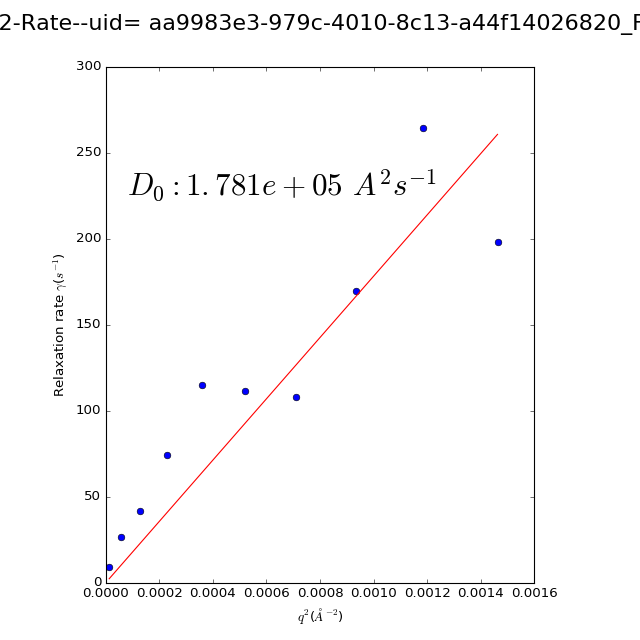

  0%|          | 0/200 [00:00<?, ?it/s]

****************************************

The 2--th uid to be analyzed is : e56ddbe5-6e10-4b79-88d1-5f0949e325b5
hdf5 path = /XF11ID/data/2016/10/31/c99f6bce-7169-4592-9e22_834_master.h5
Create a new compress file with filename as :/XF11ID/analysis/Compressed_Data/uid_e56ddbe5-6e10-4b79-88d1-5f0949e325b5.cmp.


100%|██████████| 200/200 [00:20<00:00, 10.83it/s]


The fraction of pixel occupied by photon is  1.356% 
No bad frames are involved.
10nm Au PEG 10wt.% 750Hz 200fr
With compression, the good_start frame number is: 2 


  0%|          | 0/198 [00:00<?, ?it/s]

In this g2 calculation, the buf and lev number are: 8--6--
198 frames will be processed...


100%|██████████| 198/198 [00:19<00:00,  9.67it/s]

G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/commissioning/Results/Au10nm_PEG-10wt%--Octo31/e56ddbe5-6e10-4b79-88d1-5f0949e325b5/ with filename as uid=e56ddbe5-6e10-4b79-88d1-5f0949e325b5--g2.csv


<IPython.core.display.Javascript object>


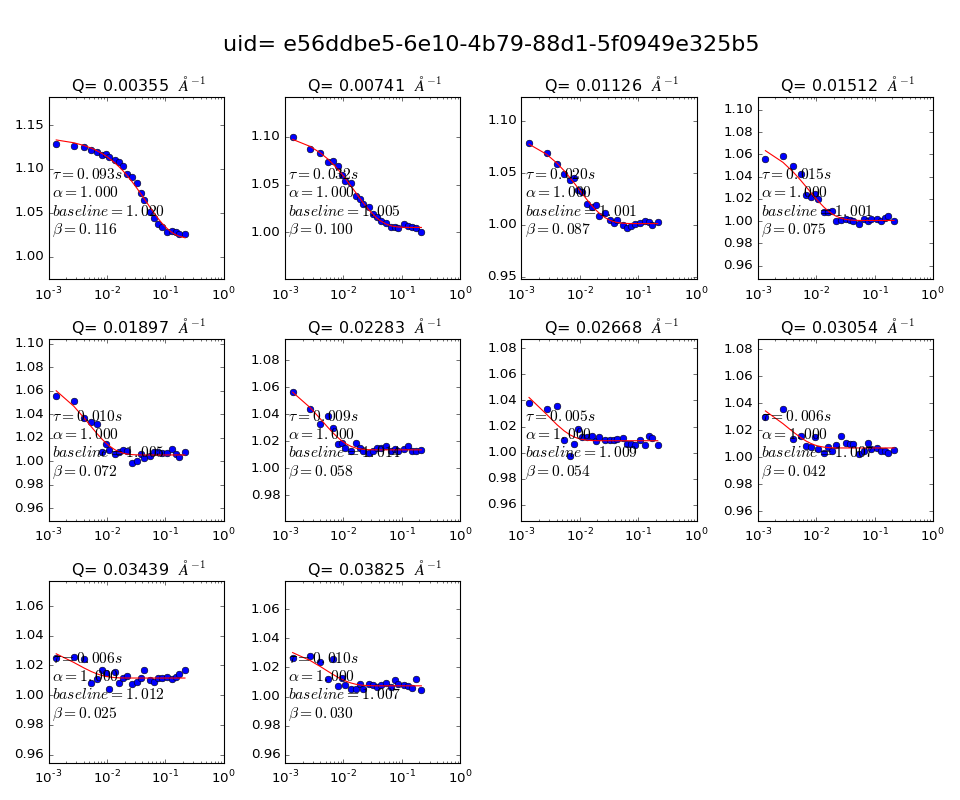

The fitted diffusion coefficient D0 is:  1.371e+05   A^2S-1


<IPython.core.display.Javascript object>


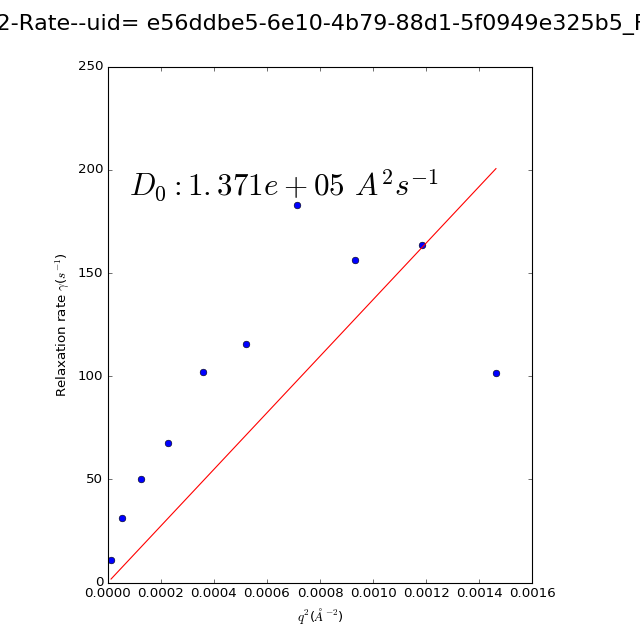

  0%|          | 1/200 [00:00<00:20,  9.81it/s]

****************************************

The 3--th uid to be analyzed is : 2fd26d5f-accb-4908-9d1e-da105e683932
hdf5 path = /XF11ID/data/2016/10/31/9deeb5de-9c36-40c5-8b74_835_master.h5
Create a new compress file with filename as :/XF11ID/analysis/Compressed_Data/uid_2fd26d5f-accb-4908-9d1e-da105e683932.cmp.


100%|██████████| 200/200 [00:20<00:00,  9.12it/s]


The fraction of pixel occupied by photon is  1.344% 
No bad frames are involved.
10nm Au PEG 10wt.% 750Hz 200fr
With compression, the good_start frame number is: 2 
In this g2 calculation, the buf and lev number are: 8--6--
198 frames will be processed...


100%|██████████| 198/198 [00:19<00:00,  9.99it/s]

G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/commissioning/Results/Au10nm_PEG-10wt%--Octo31/2fd26d5f-accb-4908-9d1e-da105e683932/ with filename as uid=2fd26d5f-accb-4908-9d1e-da105e683932--g2.csv


<IPython.core.display.Javascript object>


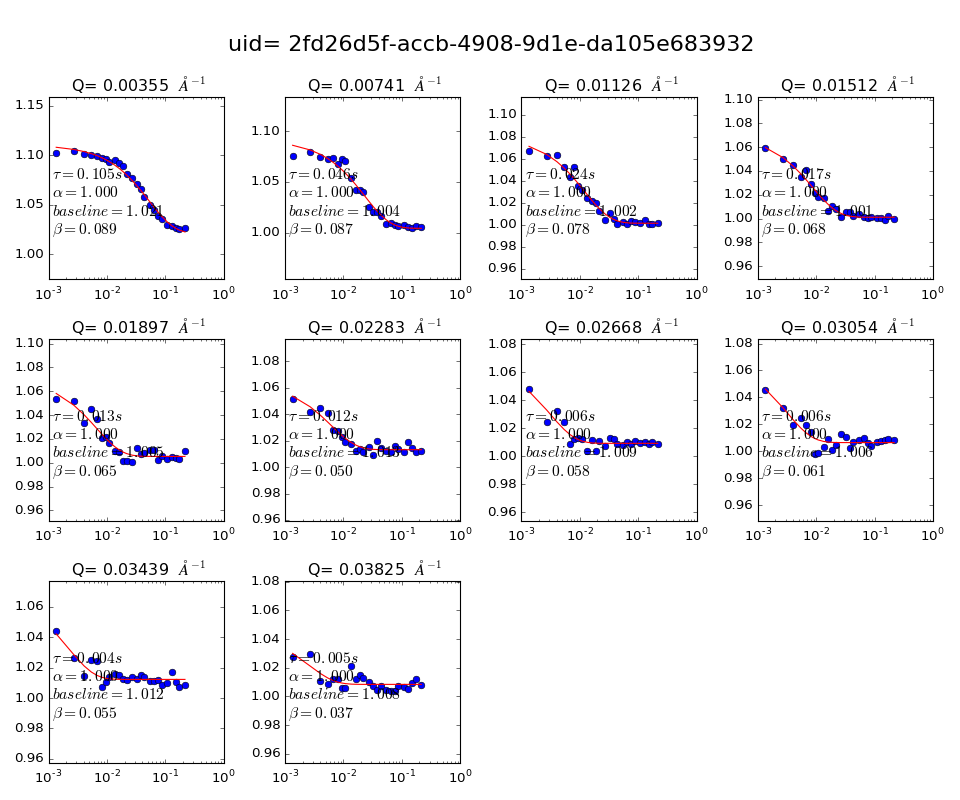

The fitted diffusion coefficient D0 is:  1.682e+05   A^2S-1


<IPython.core.display.Javascript object>


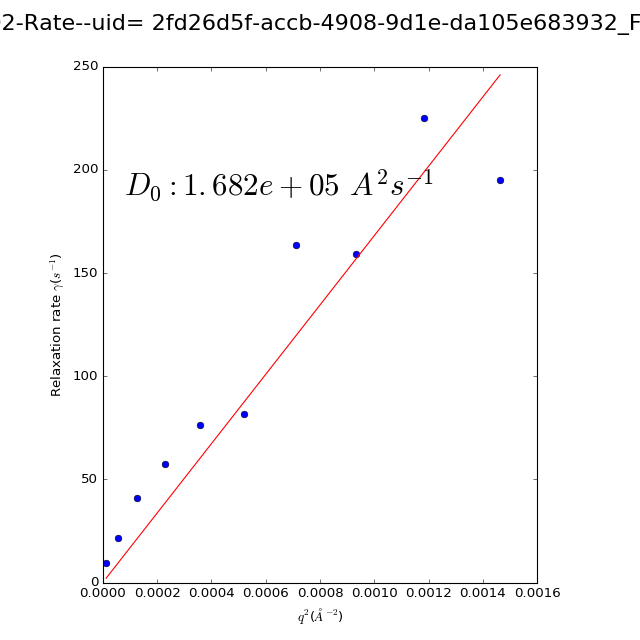

  0%|          | 1/200 [00:00<00:22,  8.89it/s]

****************************************

The 4--th uid to be analyzed is : 86525263-e276-4e87-b3e7-fdc887fa3e60
hdf5 path = /XF11ID/data/2016/10/31/76456769-3b84-4cdd-921e_836_master.h5
Create a new compress file with filename as :/XF11ID/analysis/Compressed_Data/uid_86525263-e276-4e87-b3e7-fdc887fa3e60.cmp.


100%|██████████| 200/200 [00:24<00:00,  6.20it/s]


The fraction of pixel occupied by photon is  1.394% 
No bad frames are involved.
10nm Au PEG 10wt.% 750Hz 200fr
With compression, the good_start frame number is: 2 
In this g2 calculation, the buf and lev number are: 8--6--
198 frames will be processed...


100%|██████████| 198/198 [00:20<00:00,  9.69it/s]

G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/commissioning/Results/Au10nm_PEG-10wt%--Octo31/86525263-e276-4e87-b3e7-fdc887fa3e60/ with filename as uid=86525263-e276-4e87-b3e7-fdc887fa3e60--g2.csv


<IPython.core.display.Javascript object>


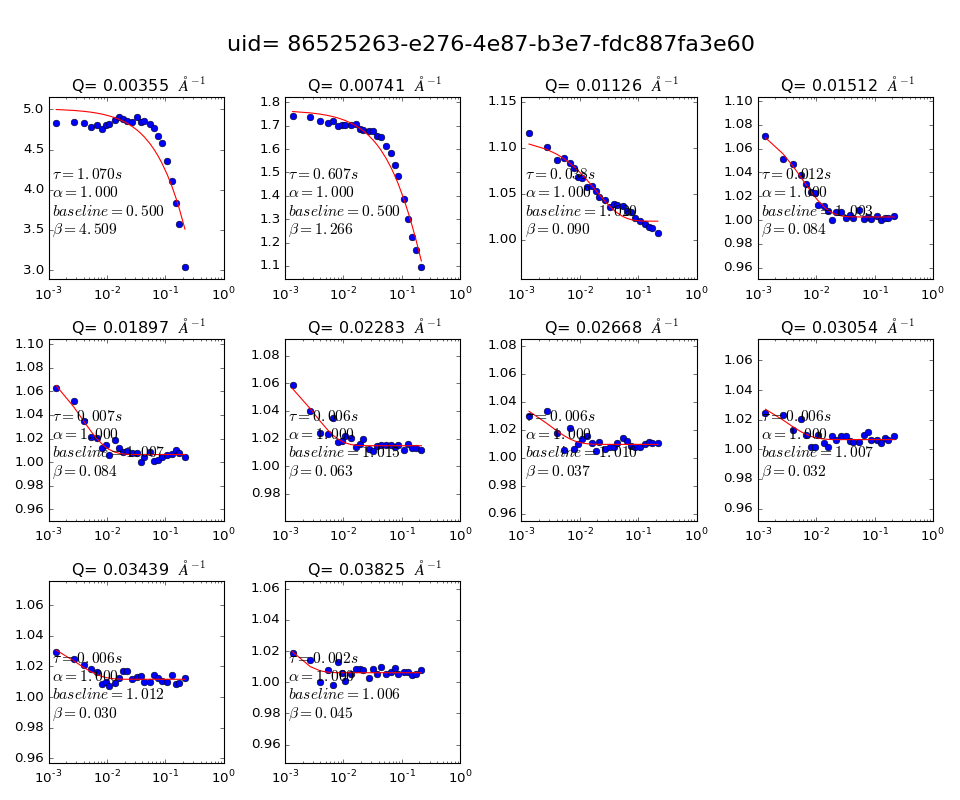

The fitted diffusion coefficient D0 is:  2.392e+05   A^2S-1


<IPython.core.display.Javascript object>


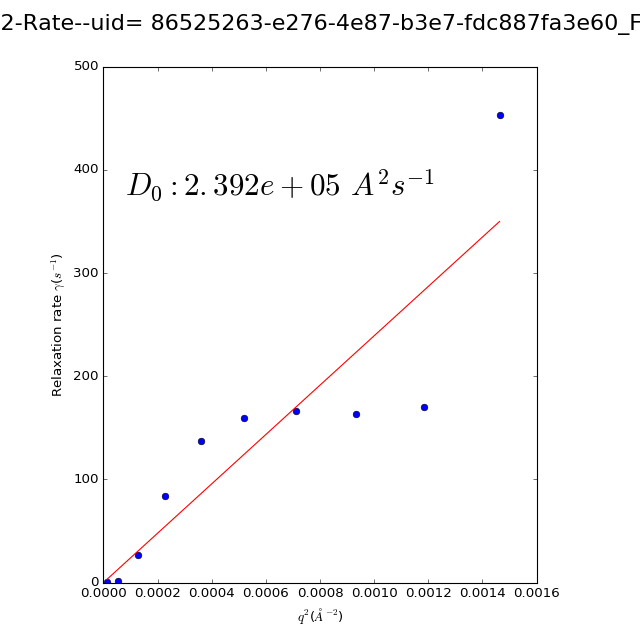

  0%|          | 1/200 [00:00<00:22,  8.88it/s]

****************************************

The 5--th uid to be analyzed is : c6c9e4c8-dd3e-4962-85bd-86c51a60f1b6
hdf5 path = /XF11ID/data/2016/10/31/c4f0bf5a-6f18-4dfe-9404_837_master.h5
Create a new compress file with filename as :/XF11ID/analysis/Compressed_Data/uid_c6c9e4c8-dd3e-4962-85bd-86c51a60f1b6.cmp.


100%|██████████| 200/200 [00:21<00:00,  9.33it/s]


The fraction of pixel occupied by photon is  1.377% 
No bad frames are involved.
10nm Au PEG 10wt.% 750Hz 200fr
With compression, the good_start frame number is: 2 


  0%|          | 0/198 [00:00<?, ?it/s]

In this g2 calculation, the buf and lev number are: 8--6--
198 frames will be processed...


100%|██████████| 198/198 [00:19<00:00,  9.90it/s]

G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/commissioning/Results/Au10nm_PEG-10wt%--Octo31/c6c9e4c8-dd3e-4962-85bd-86c51a60f1b6/ with filename as uid=c6c9e4c8-dd3e-4962-85bd-86c51a60f1b6--g2.csv


<IPython.core.display.Javascript object>


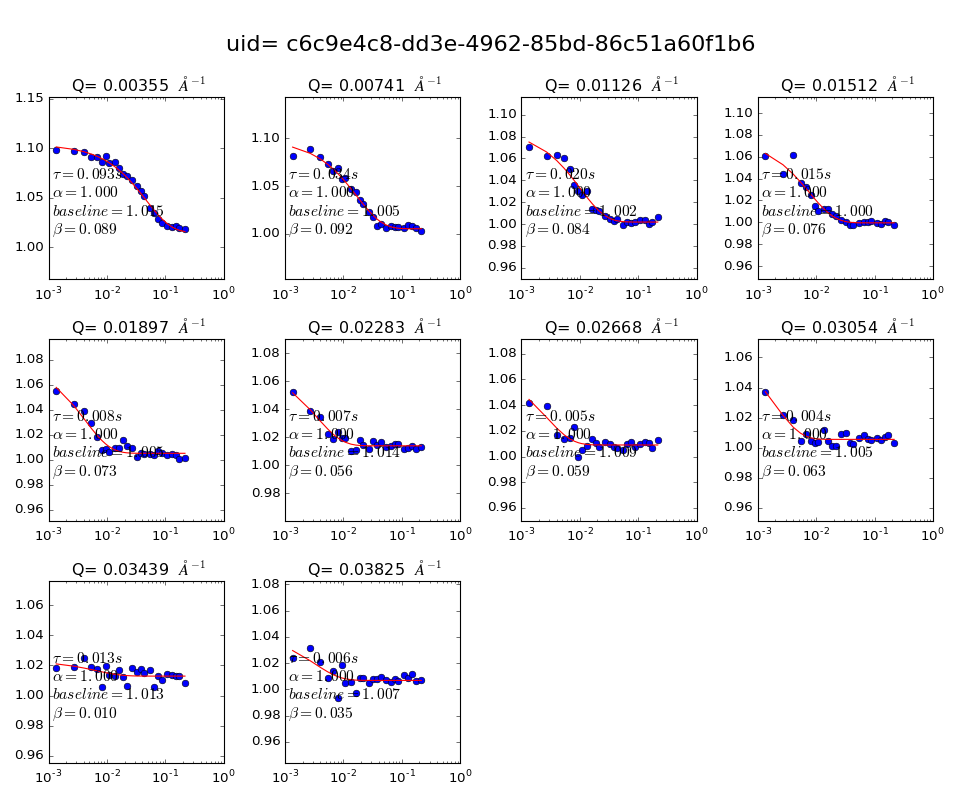

The fitted diffusion coefficient D0 is:  1.534e+05   A^2S-1


<IPython.core.display.Javascript object>


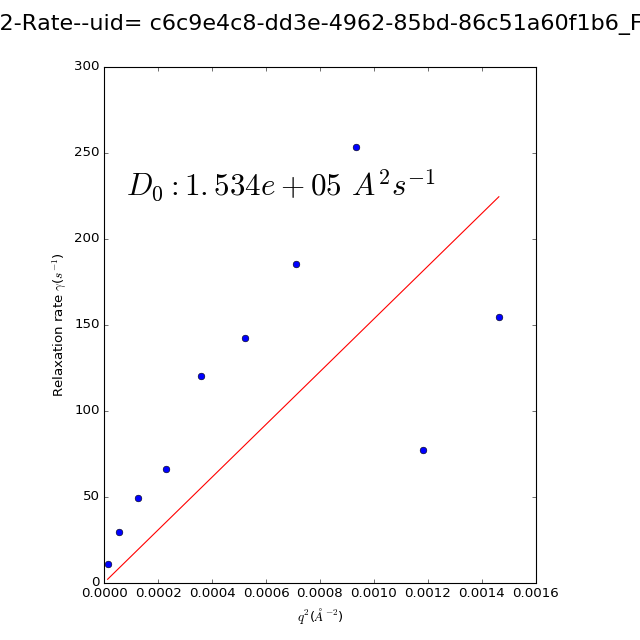

  0%|          | 0/200 [00:00<?, ?it/s]

****************************************

The 6--th uid to be analyzed is : 01e8d570-799e-41f7-8160-58a8ecfc15c4
hdf5 path = /XF11ID/data/2016/10/31/614353da-be4e-454f-9681_838_master.h5
Create a new compress file with filename as :/XF11ID/analysis/Compressed_Data/uid_01e8d570-799e-41f7-8160-58a8ecfc15c4.cmp.


100%|██████████| 200/200 [00:21<00:00,  9.41it/s]


The fraction of pixel occupied by photon is  1.380% 
No bad frames are involved.
10nm Au PEG 10wt.% 750Hz 200fr
With compression, the good_start frame number is: 2 
In this g2 calculation, the buf and lev number are: 8--6--
198 frames will be processed...


100%|██████████| 198/198 [00:19<00:00,  9.91it/s]


G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/commissioning/Results/Au10nm_PEG-10wt%--Octo31/01e8d570-799e-41f7-8160-58a8ecfc15c4/ with filename as uid=01e8d570-799e-41f7-8160-58a8ecfc15c4--g2.csv


<IPython.core.display.Javascript object>


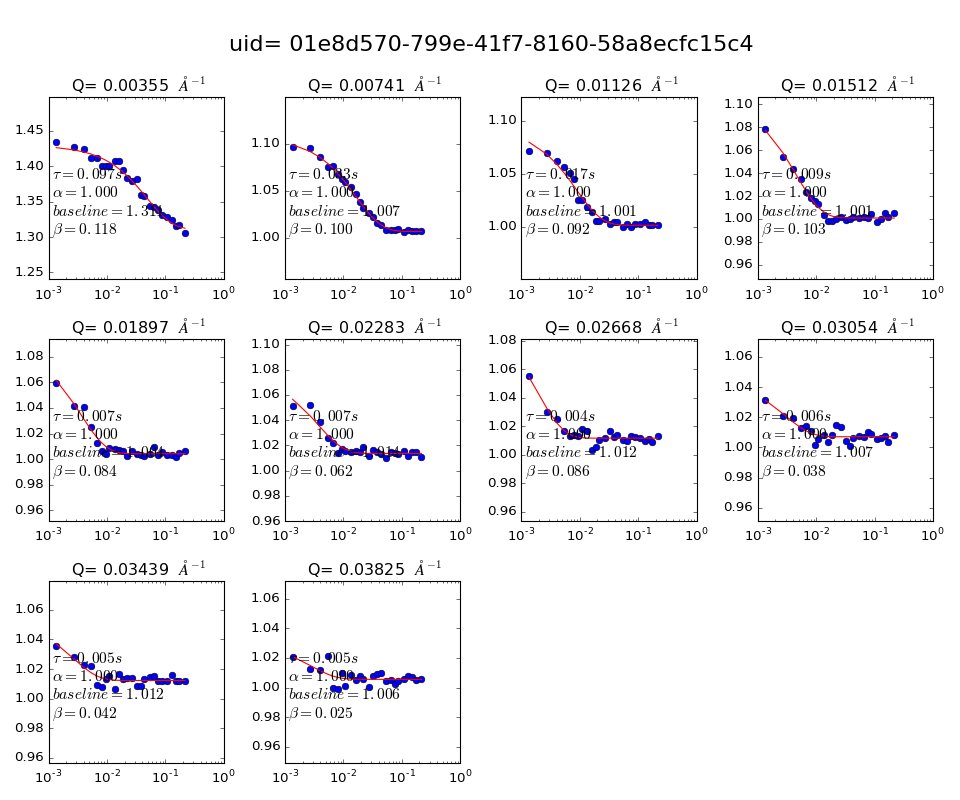

The fitted diffusion coefficient D0 is:  1.853e+05   A^2S-1


<IPython.core.display.Javascript object>


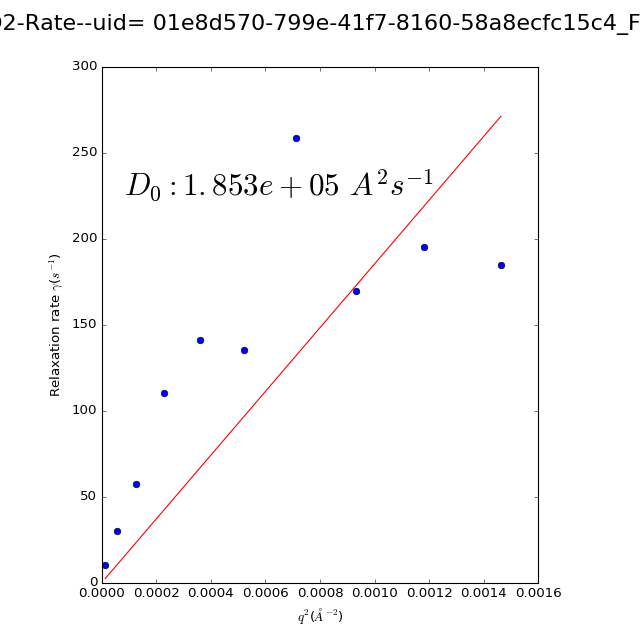

  0%|          | 0/200 [00:00<?, ?it/s]

****************************************

The 7--th uid to be analyzed is : bac795fe-2af2-44a4-82ff-84b17a5bbd6b
hdf5 path = /XF11ID/data/2016/10/31/0d552934-d6f7-4217-8360_839_master.h5
Create a new compress file with filename as :/XF11ID/analysis/Compressed_Data/uid_bac795fe-2af2-44a4-82ff-84b17a5bbd6b.cmp.


100%|██████████| 200/200 [00:21<00:00, 10.95it/s]


The fraction of pixel occupied by photon is  1.454% 
No bad frames are involved.
10nm Au PEG 10wt.% 750Hz 200fr
With compression, the good_start frame number is: 2 
In this g2 calculation, the buf and lev number are: 8--6--
198 frames will be processed...


100%|██████████| 198/198 [00:19<00:00, 10.07it/s]

G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/commissioning/Results/Au10nm_PEG-10wt%--Octo31/bac795fe-2af2-44a4-82ff-84b17a5bbd6b/ with filename as uid=bac795fe-2af2-44a4-82ff-84b17a5bbd6b--g2.csv


<IPython.core.display.Javascript object>


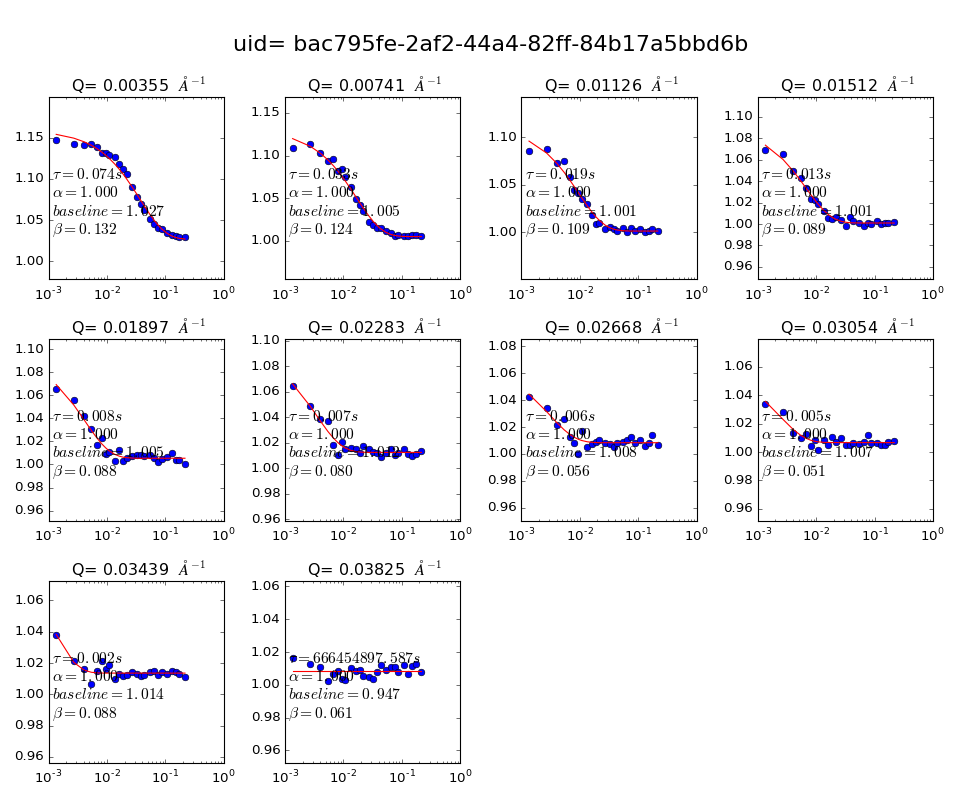

The fitted diffusion coefficient D0 is:  1.890e+05   A^2S-1


<IPython.core.display.Javascript object>


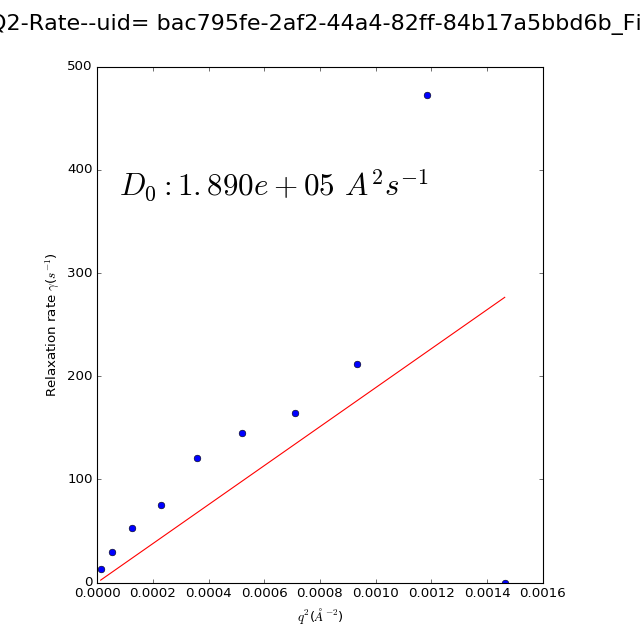

  0%|          | 1/200 [00:00<00:28,  7.08it/s]

****************************************

The 8--th uid to be analyzed is : 7444de2e-f85e-4afb-95b0-202fcf310f2f
hdf5 path = /XF11ID/data/2016/10/31/0c7e29ce-6122-412c-956d_840_master.h5
Create a new compress file with filename as :/XF11ID/analysis/Compressed_Data/uid_7444de2e-f85e-4afb-95b0-202fcf310f2f.cmp.


100%|██████████| 200/200 [00:19<00:00, 10.23it/s]


The fraction of pixel occupied by photon is  1.422% 
No bad frames are involved.
10nm Au PEG 10wt.% 750Hz 200fr
With compression, the good_start frame number is: 2 
In this g2 calculation, the buf and lev number are: 8--6--
198 frames will be processed...


100%|██████████| 198/198 [00:19<00:00,  9.90it/s]

G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/commissioning/Results/Au10nm_PEG-10wt%--Octo31/7444de2e-f85e-4afb-95b0-202fcf310f2f/ with filename as uid=7444de2e-f85e-4afb-95b0-202fcf310f2f--g2.csv


<IPython.core.display.Javascript object>


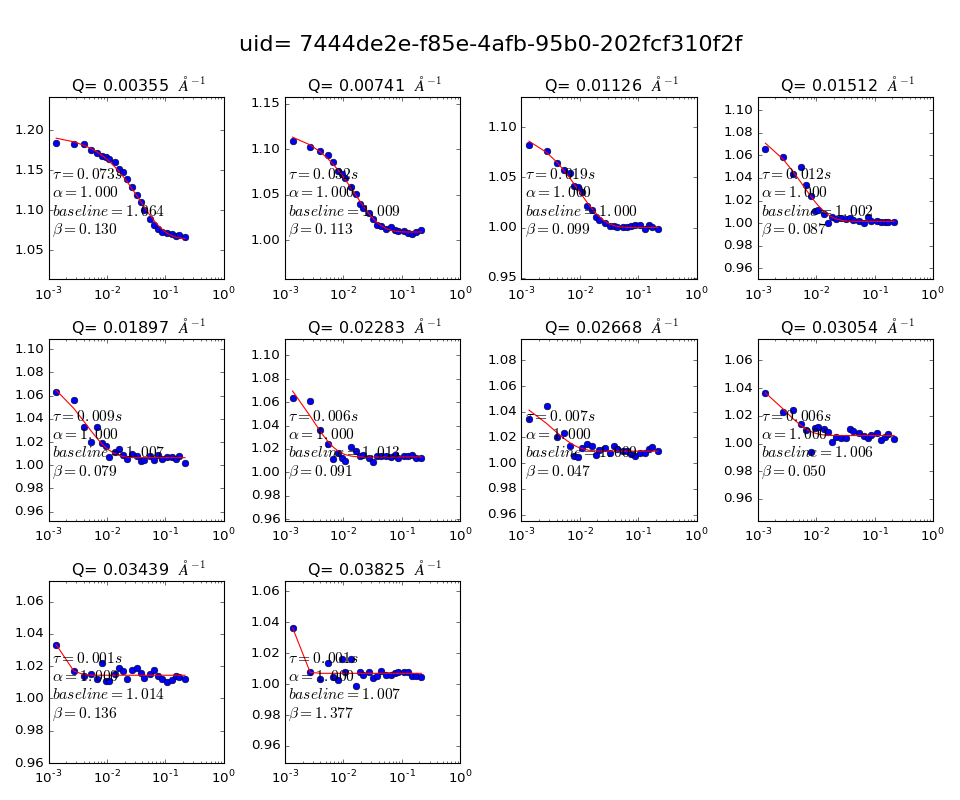

The fitted diffusion coefficient D0 is:  6.268e+05   A^2S-1


<IPython.core.display.Javascript object>


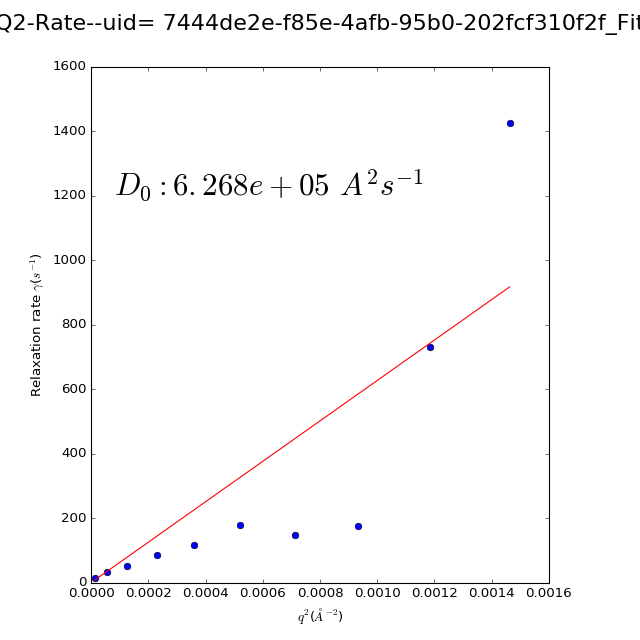

  0%|          | 0/200 [00:00<?, ?it/s]

****************************************

The 9--th uid to be analyzed is : e12c3f54-2f9a-4a97-8ae9-bd65cd404dc4
hdf5 path = /XF11ID/data/2016/10/31/89a6715f-8bc8-4a92-89ef_841_master.h5
Create a new compress file with filename as :/XF11ID/analysis/Compressed_Data/uid_e12c3f54-2f9a-4a97-8ae9-bd65cd404dc4.cmp.


100%|██████████| 200/200 [00:20<00:00,  9.94it/s]


The fraction of pixel occupied by photon is  1.399% 
No bad frames are involved.
10nm Au PEG 10wt.% 750Hz 200fr
With compression, the good_start frame number is: 2 
In this g2 calculation, the buf and lev number are: 8--6--
198 frames will be processed...


100%|██████████| 198/198 [00:19<00:00, 10.15it/s]

G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/commissioning/Results/Au10nm_PEG-10wt%--Octo31/e12c3f54-2f9a-4a97-8ae9-bd65cd404dc4/ with filename as uid=e12c3f54-2f9a-4a97-8ae9-bd65cd404dc4--g2.csv


<IPython.core.display.Javascript object>


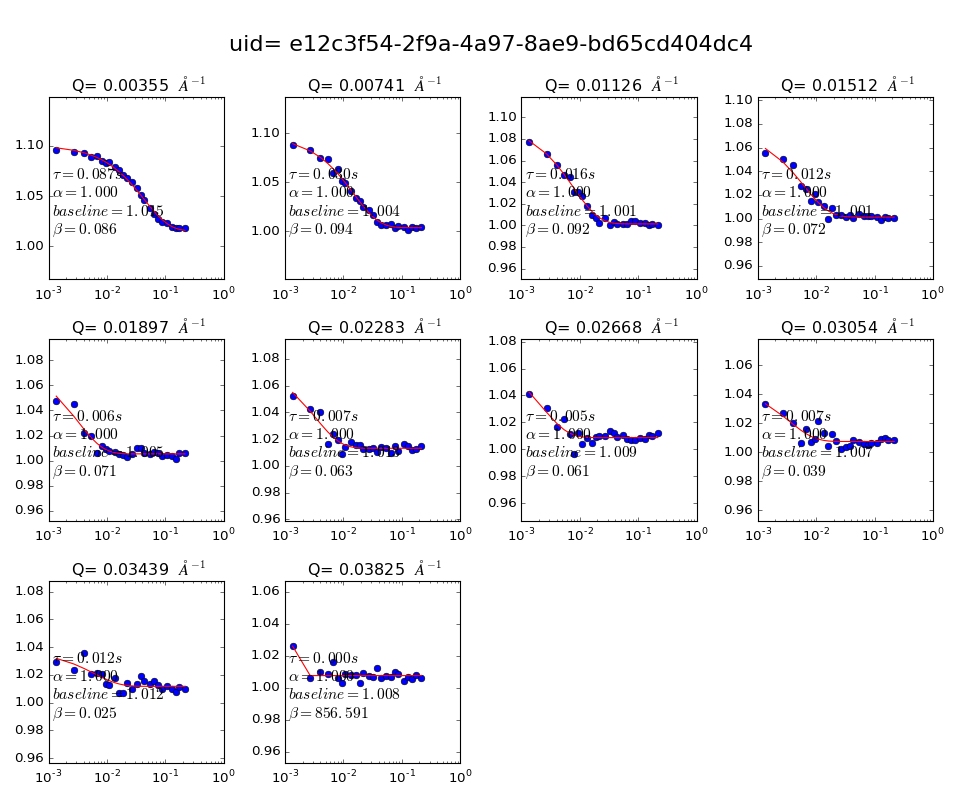

The fitted diffusion coefficient D0 is:  1.184e+06   A^2S-1


<IPython.core.display.Javascript object>


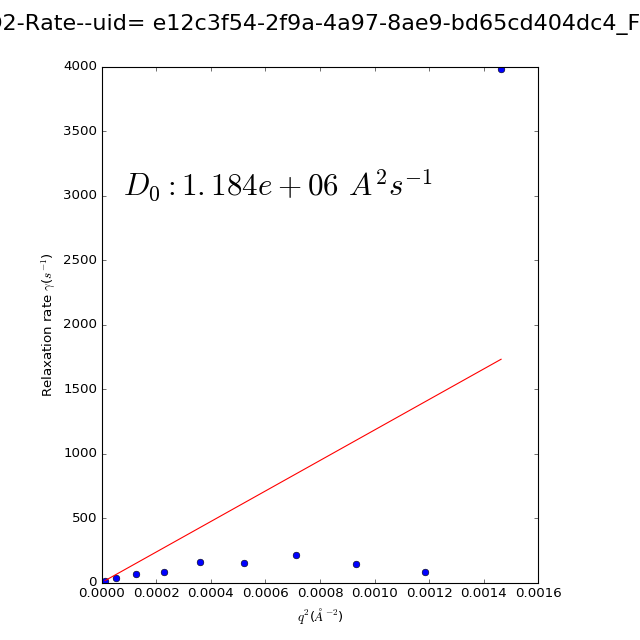

****************************************



In [97]:
g2s, taus, useful_uids  = multi_uids_saxs_xpcs_analysis(   uids, md, run_num, sub_num, fit= True, compress=True  )


## Create PDF report for each uid

In [106]:
useful_uids

{1: {1: 'a36e6012-8863-4777-81ce-1782877d4c3f',
  2: 'aa9983e3-979c-4010-8c13-a44f14026820',
  3: 'e56ddbe5-6e10-4b79-88d1-5f0949e325b5',
  4: '2fd26d5f-accb-4908-9d1e-da105e683932',
  5: '86525263-e276-4e87-b3e7-fdc887fa3e60',
  6: 'c6c9e4c8-dd3e-4962-85bd-86c51a60f1b6',
  7: '01e8d570-799e-41f7-8160-58a8ecfc15c4',
  8: 'bac795fe-2af2-44a4-82ff-84b17a5bbd6b',
  9: '7444de2e-f85e-4afb-95b0-202fcf310f2f',
  10: 'e12c3f54-2f9a-4a97-8ae9-bd65cd404dc4'}}

* Create multi PDF report for each uid

In [107]:
create_multi_pdf_reports_for_uids( useful_uids, g2s, data_dir )


****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/commissioning/Results/Au10nm_PEG-10wt%--Octo31/XPCS_Analysis_Report_for_uid=a36e6012-8863-4777-81ce-1782877d4c3f.pdf
****************************************

****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/commissioning/Results/Au10nm_PEG-10wt%--Octo31/XPCS_Analysis_Report_for_uid=aa9983e3-979c-4010-8c13-a44f14026820.pdf
****************************************

****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/commissioning/Results/Au10nm_PEG-10wt%--Octo31/XPCS_Analysis_Report_for_uid=e56ddbe5-6e10-4b79-88d1-5f0949e325b5.pdf
****************************************

****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/commissioning/Results/Au10nm_PEG-10wt%--Octo31/XPCS_Analysis_Report_for_uid=2fd26d5f-a

### Attach each g2 result to the corresponding olog entry

In [108]:
os.environ['HTTPS_PROXY'] = 'https://proxy:8888'
os.environ['no_proxy'] = 'cs.nsls2.local,localhost,127.0.0.1'

In [109]:
from chxanalys.chx_olog import LogEntry,Attachment, update_olog_uid, update_olog_id

In [110]:
for key in list( useful_uids.keys()):
    for k in list( useful_uids[key]):
        uid_k = useful_uids[key][k]
        filename = data_dir + 'XPCS_Analysis_Report_for_uid=%s.pdf'%uid_k 
        atch=[  Attachment(open(filename, 'rb')) ] 
        update_olog_uid( uid=uid_, text='Add XPCS Analysis PDF Report', attachments= atch )
     
    

## Create one PDF including all uids

In [200]:
create_one_pdf_reports_for_uids( useful_uids, g2s, data_dir, filename=uid_ )

FileNotFoundError: [Errno 2] No such file or directory: '/XF11ID/analysis/2016_3/commissioning/Results/Au10nm_PEG-10wt-Octo31/a36e6012-8863-4777-81ce-1782877d4c3f/uid=a36e6012-8863-4777-81ce-1782877d4c3f-md.pkl'

# Do average Here

In [201]:
list( g2s[1].keys() )

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [202]:
bad_uids =[ 5 ]

In [203]:
g2s_average ={} # g2s[run] = g2 of each time series average

for key in list( g2s.keys()):
    g2s_average[key] = np.zeros_like( g2s[key][1])
    i=1
    for sub_key in list( g2s[key].keys() ):
        #print (g2s_average[key].shape, g2s[key][sub_key].shape  )        
        try:
            if sub_key not in bad_uids:
                g2s_average[key] +=  g2s[key][sub_key]
                i +=1
                print( 'Run= %s--sub_run= %s-- pass'%(key, sub_key) )
                #print( 'sub= %s,Doing average here'%sub_key)
            else:
                print( 'sub= %s,Can not Doing average here'%sub_key)
                
        except:            
            print( 'sub= %s,Can not Doing average here'%sub_key)
            pass
    g2s_average[key] /= i-1

Run= 1--sub_run= 1-- pass
Run= 1--sub_run= 2-- pass
Run= 1--sub_run= 3-- pass
Run= 1--sub_run= 4-- pass
sub= 5,Can not Doing average here
Run= 1--sub_run= 6-- pass
Run= 1--sub_run= 7-- pass
Run= 1--sub_run= 8-- pass
Run= 1--sub_run= 9-- pass
Run= 1--sub_run= 10-- pass


# Save Data

In [204]:
for key in list( g2s.keys()):
    res_pargs = dict(taus=taus, q_ring_center=q_ring_center,
                  path=data_dir_, uid=  uid_ + '@run--%s'%key )
    save_saxs_g2(    g2s_average[key], res_pargs )


The correlation function is saved in /XF11ID/analysis/2016_3/commissioning/Results/Au10nm_PEG-10wt-Octo31/Average/ with filename as uid=Au10nm_PEG-10wt-Octo31@run--1--g2.csv


# Plot All the g2 Data

In [205]:
if False:
    for key in list( g2s.keys()):
        for sub_key in  list( g2s[key].keys()):
            res_pargs = dict(taus=taus, q_ring_center=q_ring_center,
                          path=data_dir_, uid=  uid_ + '@run--%s--subrun--%s'%(key, sub_key) )
            plot_saxs_g2( g2s[key][sub_key], taus,  vlim=[0.95, 1.05], res_pargs=res_pargs) 


# Plot Avergaed Data

In [206]:
if False:
    for key in list( g2s.keys()):
        res_pargs = dict(taus=taus, q_ring_center=q_ring_center,
                          path=data_dir_, uid=  uid_ + '@run--%s'%key )
        plot_saxs_g2( g2s_average[key], taus,  vlim=[0.95, 1.05], res_pargs=res_pargs) 

# Fit Averaged Data

In [207]:
fit = True

<IPython.core.display.Javascript object>


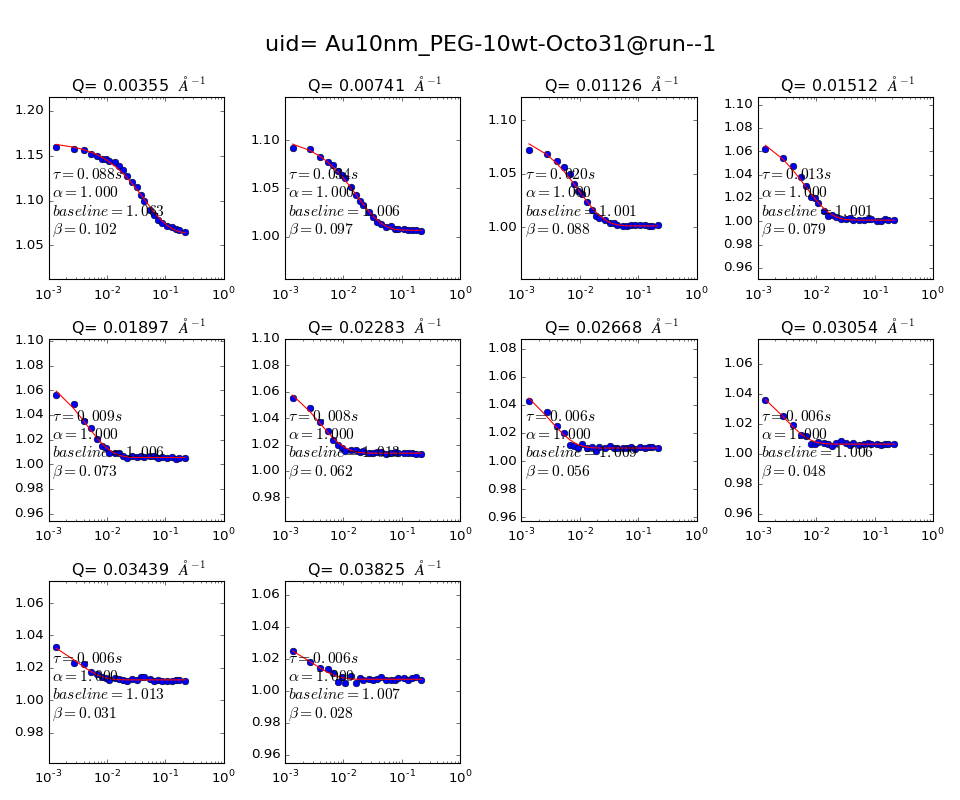

The fitted diffusion coefficient D0 is:  2.561e+05   A^2S-1


<IPython.core.display.Javascript object>


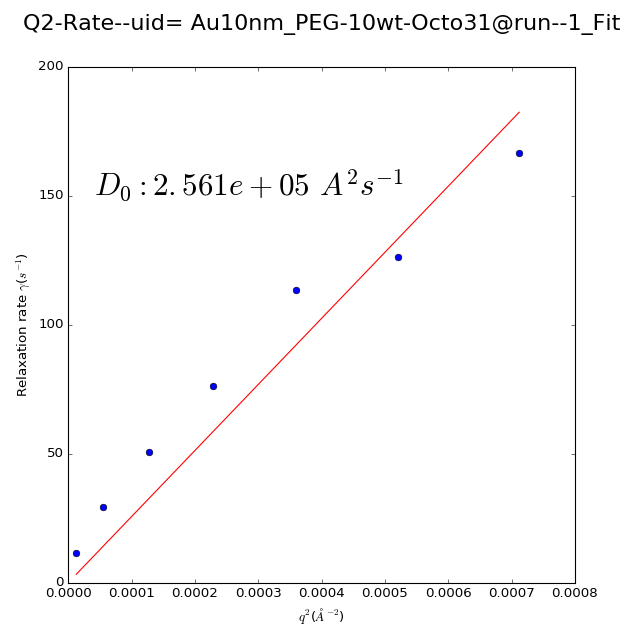

In [208]:
if fit:

    for key in list( g2s.keys()):
        res_pargs = dict(taus=taus, q_ring_center=q_ring_center,
                      path=data_dir_, uid=  uid_ + '@run--%s'%key )

        fit_result = fit_saxs_g2( g2s_average[key], res_pargs, function = 'stretched',  vlim=[0.95, 1.05], 
                    fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True},
                    guess_values={'baseline':1.45,'beta':0.08,'alpha':1.0,'relaxation_rate':0.01})
        
        #psave_obj( fit_result, data_dir + uid_ + '@run--%s'%key )
        
        fit_q_rate(  q_ring_center[:7], fit_result['rate'][:-3], power_variable= False,
           uid=uid_ + '@run--%s'%key, path= data_dir_ )

        save_lists( [q_ring_center**2,fit_result['rate']], ['q2','rate'], 
                   filename= 'Q2-rate-uid=%s'%(uid_ + '@run--%s'%key), path= data_dir)

# Create a report for the avergae g2

In [209]:
0.02/(1/750)

15.0

In [210]:
create_report = True

In [211]:
#data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')

In [212]:
pdf_out_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')
filename= "XPCS_Analysis_Report_for_uid=%s-average.pdf"%uid_
print (pdf_out_dir + filename)

/XF11ID/analysis/2016_3/commissioning/Results/XPCS_Analysis_Report_for_uid=Au10nm_PEG-10wt-Octo31-average.pdf


In [213]:
uid_

'Au10nm_PEG-10wt-Octo31'

In [214]:
if create_report:
    
    c= create_pdf_report(  data_dir_, uid_, pdf_out_dir,
                        filename= filename)
    page =1
    #Page one: Meta-data/Iq-Q/ROI
    c.report_header(page=page)
    c.report_meta( top=730)
    c.report_static( top=560)
    c.report_ROI( top= 300)
    Nk = len( list( g2s.keys()))
    Npages = Nk//2 + Nk%2
    
    for i, key in enumerate( list( g2s.keys())):        
        if not i%2:
            page += 1
            c.new_page()            
        
        c.report_header(page=page)
        if i%2:
            top = 350
        else:
            top = 720
            
        c.report_one_time( top= top, g2_fit_file =  'uid=%s@run--%s--g2--fit-.png'%(uid_,key  ),                     
                                 q_rate_file =  'uid=%s@run--%s--Q-Rate--fit-.png'%(uid_,key  ))
        
    c.save_page()
    c.done()  


****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/commissioning/Results/XPCS_Analysis_Report_for_uid=Au10nm_PEG-10wt-Octo31-average.pdf
****************************************


# The End!

In [215]:
uid_last = useful_uids[1][10]

In [219]:
#uid_last = useful_uids[1][-1]

In [216]:
c.filename

'/XF11ID/analysis/2016_3/commissioning/Results/XPCS_Analysis_Report_for_uid=Au10nm_PEG-10wt-Octo31-average.pdf'

In [217]:
#uid_ = uid_last  #useful_uids[key][k]
filename = c.filename  #XPCS_Analysis_Report_for_uid=%s.pdf'%uid_ 
atch=[  Attachment(open(filename, 'rb')) ] 
update_olog_uid( uid=uid_last, text='Add XPCS Analysis PDF Report', attachments= atch )